In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split

### Problem 3

In [3]:
df = pd.read_csv('BRCA_pam50.tsv', sep='\t', index_col=0)
X = df.iloc[:, :-1].to_numpy()
y = df['Subtype'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=17)

In [5]:
forest = RandomForestClassifier(
    random_state=17,
    class_weight='balanced'
)

In [6]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 11)),
}

In [7]:
grid = GridSearchCV(forest, params, scoring=make_scorer(balanced_accuracy_score), 
                   n_jobs=-1, cv=RepeatedStratifiedKFold(n_repeats=10))
grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring=make_scorer(balanced_accuracy_score))

In [ ]:
print(clf.best_params_)
y_pred = clf.predict(X_test)
round(balanced_accuracy_score(y_pred, y_test), 3)

In [8]:
print(grid.best_params_)

{'max_depth': 4, 'n_estimators': 50}


In [9]:
y_pred = grid.predict(X_test)

In [10]:
print(balanced_accuracy_score(y_pred, y_test))

0.8884249084249085


C:\Users\Anna\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


### Problem 4

In [108]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt

In [109]:
df = pd.read_pickle('bc_data.pkl')

In [111]:
ann = pd.read_pickle('bc_ann.pkl')

Строим первую модель (на всех генах):

In [113]:
X_train = df.loc[ann.loc[ann["Dataset type"] == "Training"].index].to_numpy()
y_train = ann.loc[ann["Dataset type"] == "Training", "Class"].to_numpy()

X_test = df.loc[ann.loc[ann["Dataset type"] == "Validation"].index].to_numpy()
y_test = ann.loc[ann["Dataset type"] == "Validation", "Class"].to_numpy()

In [114]:
model1 = SVC(kernel="linear")
model1.fit(X_train, y_train)
y_pred = model1.predict(X_train)

In [115]:
print("Balanced accuracy score on the train:", balanced_accuracy_score(y_train, y_pred))

Balanced accuracy score on the train: 1.0


In [116]:
y_pred = model1.predict(X_test)
print("Balanced accuracy score on the test:", balanced_accuracy_score(y_test, y_pred))

Balanced accuracy score on the test: 0.6041666666666666


In [117]:
M = confusion_matrix(y_test, y_pred)
TPR = M[0, 0] / (M[0, 0] + M[0, 1])
TNR = M[1, 1] / (M[1, 0] + M[1, 1])
print('TPR:', TPR, '\n', 'TNR:', TNR, '\n', 'Matrix:', '\n', M)

TPR: 0.75 
 TNR: 0.4583333333333333 
 Matrix: 
 [[54 18]
 [13 11]]


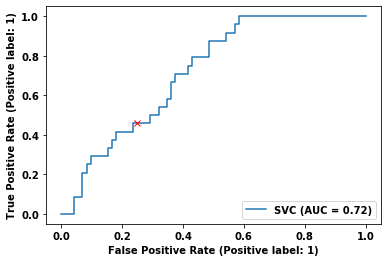

In [118]:
plot_roc_curve(model1, X_test, y_test)
plt.plot(1 - TPR, TNR, "x", c="red")
plt.show()

Строим вторую модель (на генах TRIP13;UBE2C;ZWINT;EPN3;KIF4A;ECHDC2;MTFR1;CX3CR1;SLC7A5;ABAT;CFAP69
):

In [119]:
genes = "TRIP13;UBE2C;ZWINT;EPN3;KIF4A;ECHDC2;MTFR1;STARD13;IGFBP6;NUMA1;CCNL2".split(";")

In [120]:
df_11 = df[genes]

In [121]:
X_train = df_11.loc[ann.loc[ann["Dataset type"] == "Training"].index].to_numpy()
y_train = ann.loc[ann["Dataset type"] == "Training", "Class"].to_numpy()

X_test = df_11.loc[ann.loc[ann["Dataset type"] == "Validation"].index].to_numpy()
y_test = ann.loc[ann["Dataset type"] == "Validation", "Class"].to_numpy()

In [122]:
model = SVC(kernel="linear")
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [123]:
print("Balanced accuracy score on the train:", balanced_accuracy_score(y_train, y_pred))
y_pred = model.predict(X_test)
print("Balanced accuracy score on the test:", balanced_accuracy_score(y_test, y_pred))

Balanced accuracy score on the train: 0.7246642246642246
Balanced accuracy score on the test: 0.7291666666666667


In [124]:
M = confusion_matrix(y_test, y_pred)
TPR = M[0, 0] / (M[0, 0] + M[0, 1])
TNR = M[1, 1] / (M[1, 0] + M[1, 1])
print('TPR:', TPR, '\n', 'TNR:', TNR, '\n', 'Matrix:', '\n', M)

TPR: 0.75 
 TNR: 0.7083333333333334 
 Matrix: 
 [[54 18]
 [ 7 17]]


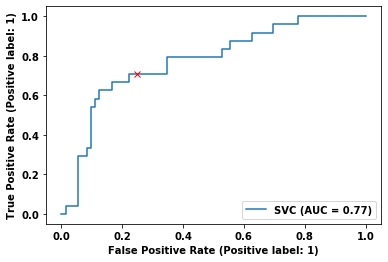

In [125]:
plot_roc_curve(model, X_test, y_test)
plt.plot(1 - TPR, TNR, "x", c="red")
plt.show()

- у второй модели выше TNR - по матрице видно, что стало больше TN
- меньше точность на тренировочной выборке, но больше на тестовой
- AUC кривая лучше (ближе к 0;1)
- Вероятно, эти результаты связаны с тем, что эти гены вносят наибольший вклад, тогда как остальные не изменяются в зависимости от класса. Это можно проверить, посмотрев коэффециенты первой модели:

In [128]:
df = df.T
df['coef'] = model1.coef_[0]
df = df.sort_values('coef', ascending = False)

In [131]:
print(df.index.tolist()[:20])

['TCN1', 'SYT1', 'NELL2', 'AGR2', 'OPRPN', 'CST5', 'TNC', 'S100P', 'CHI3L1', 'PPAT', 'NKX3-1', 'CEACAM6', 'MMP9', 'NLRP2', 'HOXC10', 'PEG10', 'DNAJC1', 'SCGB1D2', 'ENPP1', 'SPP1']


In [130]:
genes

['TRIP13',
 'UBE2C',
 'ZWINT',
 'EPN3',
 'KIF4A',
 'ECHDC2',
 'MTFR1',
 'STARD13',
 'IGFBP6',
 'NUMA1',
 'CCNL2']

Гипотеза 2: как было сказано на семинаре, для этих генов показано, что они не изменяются в зависимости от бэтча - больницы/пациента/лаборанта, поэтому по ним лучше предсказывается

### Problem 5

In [134]:
from scipy.stats import ttest_ind

df = pd.read_csv('bc_data.csv', index_col=0)
ann = pd.read_csv('bc_ann.csv', index_col=0)

df_val = df.loc[ann.loc[ann["Dataset type"] == "Validation"].index]
df_tr = df.loc[ann.loc[ann["Dataset type"] == "Training"].index]

In [135]:
genes = []
for gene in df.columns:
    t = ttest_ind(df_val[gene], df_tr[gene])[1]
    if t < 0.05:
        genes.append(gene)

In [139]:
print("The ratio is", len(genes)/len(df.columns))

The ratio is 0.6004895645452203
